In [1]:
# a demonstration of use of the two-layered neural network classifier 
# for content classification on doc2vec docs vectors
# where softmax probabilities of the classified content against the given categories can be used as relevance rating
# towards the classified categories

# references:
# [1] https://deeplearning4j.org/word2vec.html
# [2] https://deeplearning4j.org/welldressed-recommendation-engine
# [3] https://www.tensorflow.org/get_started/tflearn
# [4] http://scikit-learn.org/stable/modules/cross_validation.html

# author Michal Stefanik  mistefan  at  redhat dot com

import numpy as np
import pandas as pd
import random

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# D2VWrapper is our implementation providing vectorization of the documents based on doc2vec
from doc2vec_wrapper import D2VWrapper

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# optimization steps are reduced on TEST_MODE
TEST_MODE = False

# target categories
product_list = ["amq", "eap", "webserver", "datagrid", "fuse", "brms", "bpmsuite", "devstudio", "cdk",
                "developertoolset", "rhel", "softwarecollections", "mobileplatform", "openshift"]

In [3]:
# extended evaluation metric on selected category
def accuracy_for_category(y_expected, y_actual, label):
    label_expected = y_expected[y_expected == label]
    intersect = y_expected[np.where(y_expected == y_actual)]
    label_intersect = intersect[intersect == label]
    if len(label_expected) == 0:
        logging.warn("Accuracy of %s category evaluated on 0 samples" % label)
        return 1 if len(label_intersect) == 0 else 0
    else:
        return float(len(label_intersect)) / len(label_expected)

In [4]:
# initialize d2v_wrapper providing as well metadata about the models state
d2v_wrapper = D2VWrapper(content_categories=product_list,
                         vector_length=500)

# EITHER initialize the vocab of documents and minimize the distances of embeddings in training phase
# d2v_wrapper.init_model_vocab(content_basepath="../../data/content/playground/auto/nostem",
#                              basepath_suffix="_content.csv", drop_short_docs=10)
# d2v_wrapper.train_model(shuffle=True, epochs=1 if TEST_MODE else 15)
# 
# d2v_wrapper.persist_trained_wrapper("trained_models/wrapper/")

# OR load initialized and trained wrapper if available
d2v_wrapper.load_persisted_wrapper("trained_models/wrapper/10epoch_train_stem")

2017-04-11 10:20:40,186 : INFO : Loading serialized wrapper model from: trained_models/wrapper/10epoch_train_stem
2017-04-11 10:20:40,187 : INFO : Loading docs objects
2017-04-11 10:20:49,065 : INFO : Loading docs vectors
2017-04-11 10:21:10,841 : INFO : Loading trained Doc2Vec model
2017-04-11 10:21:10,842 : INFO : loading Doc2Vec object from trained_models/wrapper/10epoch_train_stemdoc2vec.mod
2017-04-11 10:21:11,147 : INFO : loading docvecs recursively from trained_models/wrapper/10epoch_train_stemdoc2vec.mod.docvecs.* with mmap=None
2017-04-11 10:21:11,148 : INFO : loading doctag_syn0 from trained_models/wrapper/10epoch_train_stemdoc2vec.mod.docvecs.doctag_syn0.npy with mmap=None
2017-04-11 10:21:11,334 : INFO : loading syn1neg from trained_models/wrapper/10epoch_train_stemdoc2vec.mod.syn1neg.npy with mmap=None
2017-04-11 10:21:11,475 : INFO : loading syn0 from trained_models/wrapper/10epoch_train_stemdoc2vec.mod.syn0.npy with mmap=None
2017-04-11 10:21:11,620 : INFO : setting igno

In [5]:
# transform the doc data set into a vector set of the given vector_length
doc_vectors_labeled = d2v_wrapper.infer_content_vectors()
doc_vectors = doc_vectors_labeled.iloc[:, :-1]
doc_labels = doc_vectors_labeled.iloc[:, -1]

2017-04-11 10:22:51,996 : INFO : Returning already inferred doc vectors


In [6]:
doc_labels.describe()

count     43395
unique       14
top         eap
freq      18355
Name: y, dtype: object

In [15]:
# classifier training and eval:
from sklearn.svm import LinearSVC

# results collection
accuracies = []
cat_accuracies = pd.DataFrame(columns=d2v_wrapper.content_categories)
correct_logits = pd.DataFrame(columns=["actual_prob", "expected_prob", "actual_class", "expected_class"])
wrong_docs_ids = pd.Series()

# evaluation on CV split persisting the categories respective size on each split
strat_kfold = StratifiedKFold(n_splits=5 if TEST_MODE else 5, shuffle=True)

for train_doc_indices, test_doc_indices in strat_kfold.split(doc_vectors, doc_labels):
    logging.info("Shuffling indices")
    random.shuffle(train_doc_indices)
    random.shuffle(test_doc_indices)

    # training
    svm_classifier = LinearSVC(C=0.1)
    
    logging.info("Fitting classifier")
    svm_classifier.fit(doc_vectors.iloc[train_doc_indices], doc_labels.iloc[train_doc_indices])

    # testing
    logging.info("Predicting")
    y_expected = doc_labels.iloc[test_doc_indices].values
    y_actual = svm_classifier.predict(doc_vectors.iloc[test_doc_indices])

    # evaluation:
    # logits
    logging.info("Probs collection")
    class_probs = svm_classifier.decision_function(doc_vectors.iloc[test_doc_indices])
    class_ordered = list(svm_classifier.classes_)

    class_actual_index = pd.Series(y_actual).apply(lambda cat_label: class_ordered.index(cat_label))
    actual_prob = class_probs[np.arange(len(class_actual_index)), (class_actual_index)]

    class_expected_index = pd.Series(y_expected).apply(lambda cat_label: class_ordered.index(cat_label))
    expected_prob = class_probs[np.arange(len(class_actual_index)), (class_expected_index)]

    new_logits = pd.DataFrame()
    new_logits["actual_prob"] = actual_prob
    new_logits["expected_prob"] = expected_prob
    new_logits["actual_class"] = y_actual
    new_logits["expected_class"] = y_expected
    correct_logits = correct_logits.append(new_logits)

    # accuracy
    logging.info("Split results:")
    split_accuracy = accuracy_score(y_expected, y_actual)
    logging.info("Run accuracy: %s" % split_accuracy)
    accuracies.append(split_accuracy)
    split_cat_accuracies = map(lambda cat: accuracy_for_category(y_expected, y_actual, cat),
                               d2v_wrapper.content_categories)
    logging.info("Cat accuracies:\n%s" % split_cat_accuracies)
    cat_accuracies = cat_accuracies.append(
        pd.DataFrame(data=[split_cat_accuracies], columns=d2v_wrapper.content_categories))

2017-04-11 10:28:43,816 : INFO : Shuffling indices
2017-04-11 10:28:43,866 : INFO : Fitting classifier
2017-04-11 10:29:15,076 : INFO : Predicting
2017-04-11 10:29:15,238 : INFO : Probs collection
2017-04-11 10:29:15,416 : INFO : Split results:
2017-04-11 10:29:15,422 : INFO : Run accuracy: 0.839014279134
2017-04-11 10:29:15,430 : INFO : Cat accuracies:
[0.304, 0.925905747752656, 0.30386740331491713, 0.45614035087719296, 0.8396293656450463, 0.4358974358974359, 0.517948717948718, 0.7511380880121397, 0.07142857142857142, 0.0, 0.9299314546839299, 0.0, 0.42857142857142855, 0.8190830235439901]
2017-04-11 10:29:15,432 : INFO : Shuffling indices
2017-04-11 10:29:15,484 : INFO : Fitting classifier
2017-04-11 10:29:43,501 : INFO : Predicting
2017-04-11 10:29:43,637 : INFO : Probs collection
2017-04-11 10:29:43,783 : INFO : Split results:
2017-04-11 10:29:43,788 : INFO : Run accuracy: 0.838152286603
2017-04-11 10:29:43,794 : INFO : Cat accuracies:
[0.272, 0.9351675292835739, 0.24861878453038674,

In [16]:
logging.info("split accuracies: %s" % accuracies)
logging.info("mean accuracy: %s" % np.mean(accuracies))
logging.info("categories accuracies: \n%s" % cat_accuracies)
logging.info("categories accuracies mean: \n%s" % cat_accuracies.mean())
logging.info("done")

2017-04-11 10:32:11,549 : INFO : split accuracies: [0.83901427913403959, 0.83815228660292596, 0.83072136436967048, 0.83704045176904462, 0.83481268011527376]
2017-04-11 10:32:11,550 : INFO : mean accuracy: 0.835948212398
2017-04-11 10:32:11,560 : INFO : categories accuracies: 
     amq       eap  webserver  datagrid      fuse      brms  bpmsuite  \
0  0.304  0.925906   0.303867  0.456140  0.839629  0.435897  0.517949   
0  0.272  0.935168   0.248619  0.315789  0.874555  0.407725  0.492308   
0  0.240  0.923182   0.209945  0.315789  0.854597  0.407725  0.528205   
0  0.240  0.932171   0.298343  0.333333  0.850321  0.424893  0.489691   
0  0.168  0.928357   0.227778  0.456140  0.857448  0.450644  0.479381   

   devstudio       cdk  developertoolset      rhel  softwarecollections  \
0   0.751138  0.071429               0.0  0.929931                  0.0   
0   0.747720  0.142857               0.0  0.928408                  0.0   
0   0.741641  0.071429               0.0  0.927591         

In [11]:
# accuracies of categories together with their size

labels_size = pd.DataFrame()
labels_size["label"] = doc_labels.unique()
labels_size["accuracy"] = cat_accuracies.mean().values
labels_size["size"] = [len(doc_labels[doc_labels == cat]) for cat in labels_size["label"]]
labels_size = labels_size.sort_values(by=["size"])

labels_size

,label,accuracy,size
11,softwarecollections,0.000000,5
9,developertoolset,0.000000,12
8,cdk,0.014286,69
12,mobileplatform,0.119048,101
3,datagrid,0.210526,285
0,amq,0.185600,625
2,webserver,0.212382,904
6,bpmsuite,0.488195,973
5,brms,0.431408,1166
7,devstudio,0.736251,3291


In [12]:
# computed actual_prob probabilities might be used as ranking system of the relevance of documents towards categories
correct_logits.head(25)

,actual_prob,expected_prob,actual_class,expected_class
0,0.209962,0.209962,eap,eap
1,-0.509608,-0.523146,fuse,eap
2,0.383700,0.383700,fuse,fuse
3,0.380885,-1.407061,eap,rhel
4,0.470171,0.470171,eap,eap
5,-0.602315,-0.749417,brms,bpmsuite
6,0.856199,0.856199,rhel,rhel
7,0.545893,0.545893,eap,eap
8,-0.048996,-1.036474,eap,openshift
9,-0.271008,-0.532023,fuse,eap


In [17]:
biggest_cats = labels_size["label"][-6:]
biggest_cats_df = correct_logits[correct_logits["expected_class"].isin(biggest_cats)]
biggest_cats_df["expected_class"].unique()

array(['openshift', 'rhel', 'eap', 'fuse', 'devstudio', 'brms'], dtype=object)

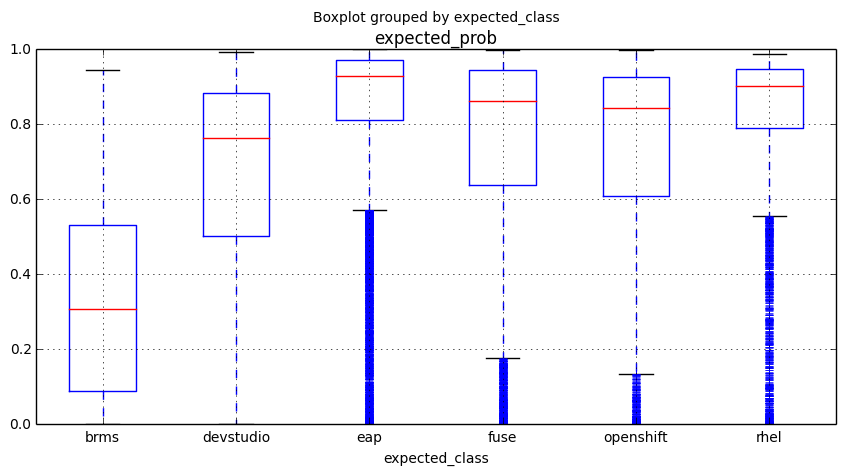

In [18]:
# boxplot visualization of the scores of documents against its own category (biggest 6 classes)
# the higher the better
# we see that it goes much better for bigger categories

# boxplot: 50% of data in box, 90% in dashed intervals
%matplotlib inline
import matplotlib.pyplot as plt

join_label_size = labels_size
join_label_size["expected_class"] = join_label_size["label"]

biggest_cats_df.boxplot("expected_prob", by="expected_class", figsize=(10,5))

In [19]:
# incorrect classification characteristics
wrong_docs_wordlist = wrong_docs_ids.apply(lambda doc_id: d2v_wrapper.all_content_tagged_docs.iloc[doc_id].words)
wrong_docs_len = wrong_docs_wordlist.apply(lambda doc: len(doc))

wrong_docs_len.describe()

count     6821.000000
mean       145.372233
std       1031.526677
min         10.000000
25%         19.000000
50%         33.000000
75%         76.000000
max      79212.000000
dtype: float64

In [20]:
# correct classification characteristics
all_indices = pd.Series(np.arange(len(doc_vectors)))
correct_docs =  all_indices[~all_indices.isin(wrong_docs_ids)]
correct_docs_wordlist = correct_docs.apply(lambda doc_id: d2v_wrapper.all_content_tagged_docs.iloc[doc_id].words)
correct_docs_len = correct_docs_wordlist.apply(lambda doc: len(doc))

correct_docs_len.describe()

count    36657.000000
mean       135.858390
std        487.444108
min         10.000000
25%         26.000000
50%         41.000000
75%        105.000000
max      56006.000000
dtype: float64